##### Copyright 2019 The TensorFlow Authors.

In [14]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.



# Load images

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/load_data/images"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/load_data/images.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/load_data/images.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/load_data/images.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial provides a simple example of how to load an image dataset using `tf.data`.

The dataset used in this example is distributed as directories of images, with one class of image per directory.

## Setup

In [7]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [8]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf


In [9]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [13]:
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os, glob, pathlib

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import numpy as np
import matplotlib.pyplot as plt

In [14]:
tf.__version__

'2.0.0-beta1'

### Retrieve the images

Before you start any training, you will need a set of images to teach the network about the new classes you want to recognize. You can use an archive of creative-commons licensed flower photos from Google.

Note: all images are licensed CC-BY, creators are listed in the `LICENSE.txt` file.

In [15]:
data_dir = pathlib.Path('inv/UmojaHack_1_invertebrates/train_small')


image_count = len(list(data_dir.glob('*/*.jpeg')))

print(f'The image count is {image_count}')




The image count is 3111


In [16]:
train_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our training data
validation_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our validation data

BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224

STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)

CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != "submission.csv"]) 

b'inv/UmojaHack_1_invertebrates/train_small'


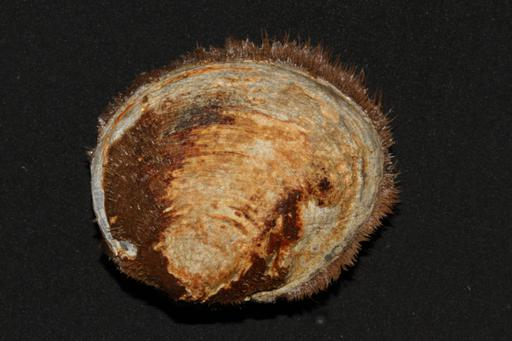

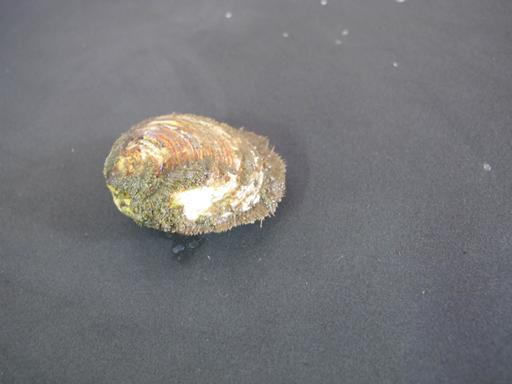

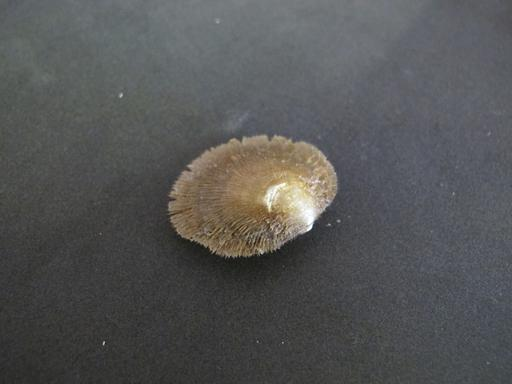

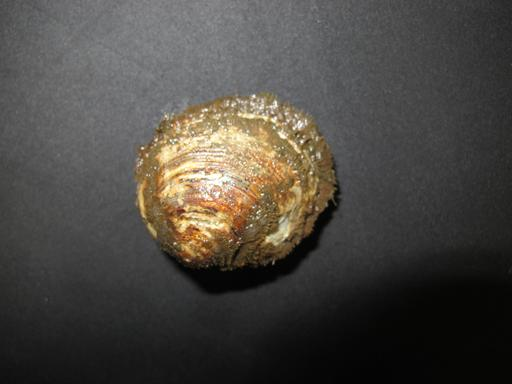

In [20]:
list_ds = tf.data.Dataset.list_files(str(data_dir))

for f in list_ds.take(5):
  print(f.numpy())

lim = list(data_dir.glob('Limopsis_chuni/*'))

for image_path in lim[:4]:
    display.display(Image.open(str(image_path)))


Each directory contains images of that type of flower. Here are some roses:

In [18]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  return parts[-2] == CLASS_NAMES

def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

## Use Dataset.map to create a dataset of image, label pairs:

Write a short pure-tensorflow function that converts a file paths to an (image_data, label) pair:

### Basic methods for training

To train a model with this dataset you will want the data:

* To be well shuffled.
* To be batched.
* Batches to be available as soon as possible.

These features can be easily added using the `tf.data` api.

Let's compare the speed of the two data generators:

A large part of the performance gain comes from the use of `.cache`.